<img style="float: right;width: 100px" src="https://www.enib.fr/images/logo-enib-accueil.jpg">

# Electronique S4 
# prise en main des fonctions scipy permettant l'étude des filtres ordre n


In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import lib_electronic_V3 as lib
import warnings
import SecondOrderElec as sc
import math
warnings.filterwarnings('ignore')

## definition du gabarit passe bas recherché
On recherche un filtre permettant de laisser passer les signaux jusqu'à 2kHz avec une bande passante de 3dB puis de les atténuer d'au moins 80dB à partir de 10kHz

### définitions des valeurs permettant de tracer le gabarit

In [2]:
fc = 3000
fs = 18000
T0 = 1
Gc = 2 # dB
Gs = 80 # dB
Tc = 10**(-Gc/20)
Ts = 10**(-Gs/20)
print( "Tc (naturel)=", Tc, "Ts (naturel) =", Ts)
print("bande passante (dB)=", Gc, "attenuation min dans stop band (dB) =", Gs)

Tc (naturel)= 0.7943282347242815 Ts (naturel) = 0.0001
bande passante (dB)= 2 attenuation min dans stop band (dB) = 80


### Calcul de l'ordre min du filtre permettant de passer la courbe de module dans le gabarit

In [3]:
N=math.ceil(-math.log(Ts/Tc)/math.log(fs/fc))
N

6

### Tracé du gabarit
une bibliotheque est fournie

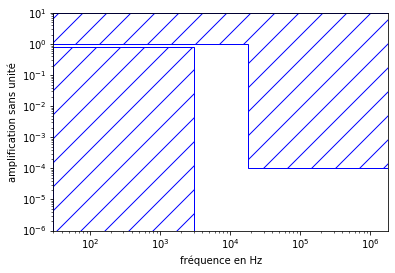

In [4]:
lib.draw_prototype(fc,Tc,fs,Ts,filter_type="lowpass",xaxes_type="f", yaxes_type = "T")


## normalisation des données pour utilisation des fonctions scipy et travail sur polynomes normalisés

In [5]:
wc =1
#pour la fonction elliptique (filtres de Cauer) l'ordre et la pulsation sont à calculer différement
Nc, wcc = sig.ellipord(fc, fs, gpass=Gc, gstop=Gs, analog=True)
xcc = wcc/(fc*2*np.pi)

Nc, wcc

(4, 3000.0)

## Tracé du gabarit normalisé¶

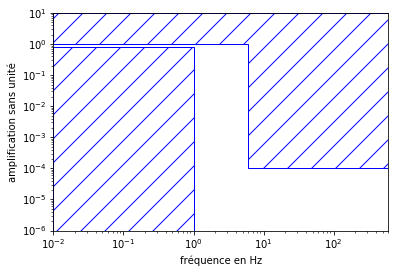

In [6]:
S = fs/fc
lib.draw_prototype(wc, Tc, S, Ts, filter_type="lowpass",xaxes_type="f", yaxes_type = "T")

## definition des systèmes linéaires normalisés en utilisant les approximations
Plusieurs approximations des polynomes dénominateurs permettent de rentrer dans le gabarit demandé.
Des fonctions définies dans la bibliothèques scipy sont utilisées : 
* butter : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
* cheby1 (ondulation dans la bande passante et non dans la bande coupée) : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby1.html
* bessel : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html
* ellip pour les filtres de Cauer encore appelés filtres elliptiques : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html
Lire la documentation et vérfier le bon paramétrage des fonctions appelées ci dessous

In [7]:
[z1,p1,k1] = sig.butter(N,wc,btype='low',analog=True,output='zpk')
H_butter=sig.lti(z1,p1,k1)
[z2,p2,k2] = sig.cheby1(N,np.abs(Gc),wc,btype='low',analog=True,output='zpk')
H_cheby = sig.lti(z2,p2,k2)
# filtre bessel optimisé pour respecter la pulsation de cassure à -3dB - paramètre norm = 'mag'
[z3,p3,k3]= sig.bessel(N, wc, btype='low',analog=True,norm = 'mag', output='zpk')
H_bessel = sig.lti(z3,p3,k3)
# filtre bessel optimisé pour respecter la linéarité de phase autour de wC- paramètre norm = 'phase'
[z3phi,p3phi,k3phi] = sig.bessel(N, wc, btype='low',analog=True,norm = 'phase', output='zpk')
H_bessel_phi = sig.lti(z3phi,p3phi,k3phi)
# filtre bessel optimisé pour respecter la temps de propagation de groupe en 1/wC- paramètre norm
[z3delay,p3delay,k3delay] = sig.bessel(N, wc, btype='low',analog=True,norm = 'delay', output='zpk')
H_bessel_tps = sig.lti(z3delay,p3delay,k3delay)
#filtre cauer avec ordre spécifique
[z4,p4,k4] = sig.ellip(Nc,np.abs(Gc),np.abs(Gs),xcc,btype='low',analog=True,output='zpk')
H_cauer = sig.lti(z4,p4,k4)

## Diagramme des pôles et zéros sur axes normalisés par rapport à wc
générer les pôles de chacun des systemes lti définis.
on rappelle que les atributs .poles et .zeros sont directement définis pour la classe lti
Représenter ensuite tous les pôles dans le même repère et retrouver les propriétés de chacune des approximations

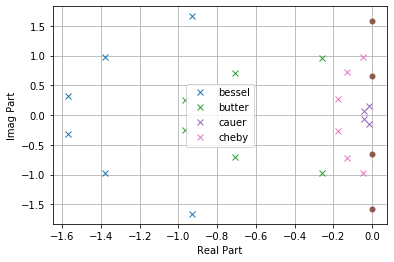

In [8]:
systems = {
    'bessel':H_bessel,
    'butter':H_butter,
    'cauer':H_cauer,
    'cheby':H_cheby
    }
for name, lti in systems.items():
    plt.plot(lti.poles.real, lti.poles.imag, "x", markersize=6, label=name)
    plt.plot(lti.zeros.real, lti.zeros.imag, "o", markersize=5)
    plt.legend()
plt.grid()
plt.xlabel("Real Part")
a=plt.ylabel("Imag Part")

Les pôles de Bessel sont les plus éloignés de l'axes des imaginaires donc pour chaque paire de de poles complexes conjugués on a un m relativement grand donc un temps de stabilisation petit. 
Chebychev et Cauer à l'inverse donneront des réponses indicielles très oscillantes et lente à stabiliser.
Butterworth est un bon compromis.

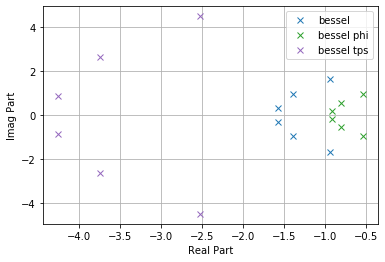

In [9]:
systems = {
    'bessel':H_bessel,
    'bessel phi':H_bessel_phi,
    'bessel tps':H_bessel_tps
    }
for name, lti in systems.items():
    plt.plot(lti.poles.real, lti.poles.imag, "x", markersize=6, label=name)
    plt.plot(lti.zeros.real, lti.zeros.imag, "o", markersize=5)
    plt.legend()
plt.grid()
plt.xlabel("Real Part")
a=plt.ylabel("Imag Part")

Voici différentes variantes de Bessel. Elles sont optimisées différent:

- $bessel$ : optimisation du respect du gabarit
- $bessel phi$: optimisation de la linéarité de la phase
- $bessel tps$: optimisation de la réponse indicielle, elle ne dépassera pas le régime continu.

### représentation dénormalisée (axes en rad/s)
Revenir au diagramme sur repère en rad/s

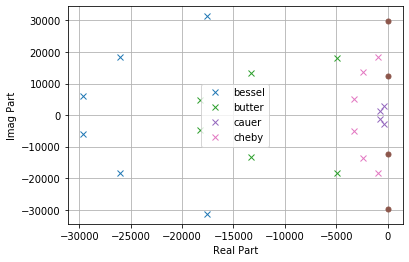

In [10]:
systems = {
    'bessel':H_bessel,
    'butter':H_butter,
    'cauer':H_cauer,
    'cheby':H_cheby
    }
for name, lti in systems.items():
    plt.plot(lti.poles.real*(2*np.pi*fc), lti.poles.imag*(2*np.pi*fc), "x", markersize=6, label=name)
    plt.plot(lti.zeros.real*(2*np.pi*fc), lti.zeros.imag*(2*np.pi*fc), "o", markersize=5)
    plt.legend()
plt.grid()
plt.xlabel("Real Part")
a=plt.ylabel("Imag Part")

## Création des polynomes numérateurs et dénominateurs normalisés
Plusieurs options permettent de renvoyer les pôles, zéros et le gain (coefficient amplificateur du numérateur) d'un systeme lti ou les coefficients de son numérateurs et son dénominateurles systemes lti )...

In [11]:
# PAS COMPRIS

# Diagrammes de Bode
Trouver dans la bibliothèque fournie les fonction permettant d'afficher les diagrammes de Bode des différents systèmes lti définis plus haut

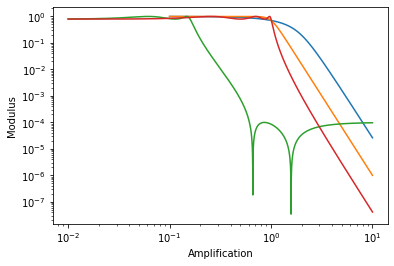

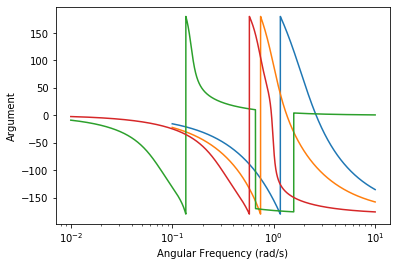

In [12]:
systems = {
    'bessel':H_bessel,
    'butter':H_butter,
    'cauer':H_cauer,
    'cheby':H_cheby
    }
for name, lti in systems.items():
    num, den = lti.to_tf().num,lti.to_tf().den 
    sc.plot.plot_bode(*sig.lti(num, den).freqresp())


### zoom autour de f/fc=1

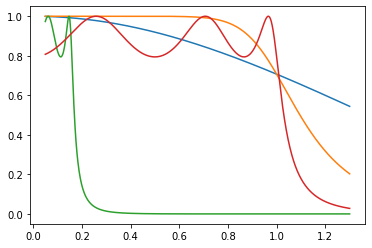

In [13]:
systems = {
    'bessel':H_bessel,
    'butter':H_butter,
    'cauer':H_cauer,
    'cheby':H_cheby
    }

T = np.linspace(0.05,1.3,1000)
for name, lti in systems.items():
    num, den = lti.to_tf().num,lti.to_tf().den 
    t_2, r_2 = sig.lti(num, den).freqresp(T)
    plt.plot(t_2, abs(r_2))

#plt.plot(t_2, np.angle(r_2))


# reponses indicielles

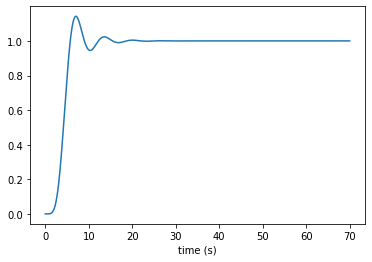

In [14]:
t_e = np.arange(0,70/wc,0.00001)
[t_1, imp_1] = H_butter.step(T=t_e)
[t_1, imp_1]
sc.plot.plot_time(t_1, imp_1)

### Analyse plus spécifique des extremas pour chebishev

* pulsations propre et coefficients d'amortissement des différentes paires de pôles

* fréquences de résonance des cellules

* fréquences des extrema de la courbe de module dans la bande passante

# etude des polynomes-extraction des racines
vous présenterez ici les polynomes normalisés factorisés en terme d'ordre 2 et 1 et les couples FSF et Q de chaque cellule correspondante.
Vous pourrez vérifier que les pôle dénormalisés donnent bien des couples m et w0 cohérents.

* Butterworth

In [15]:
print("coefficients du dénominateur de Butterworth", den1)
r1=.roots(den1)
print("racines du dénominateur",r1)
r1_norm = r1/wc
print("racines normalisées par rapport à wC",r1_norm)




SyntaxError: invalid syntax (<ipython-input-15-c35156dba829>, line 2)

* Chebyshev

In [26]:
for pol in H_cheby.poles:
    print(pol, "module :", abs(pol), "real :", pol.real, '     m = ', -pol.real/abs(pol), 'w0 =', abs(pol)*2*np.pi*fc, 'rad/s')

(-0.046973215460233426+0.9817051722039067j) module : 0.982828330942172 real : -0.046973215460233426      m =  0.04779391678219464 w0 = 18525.877585367074 rad/s
(-0.12833321123223762+0.7186580641064136j) module : 0.7300265928103964 real : -0.12833321123223762      m =  0.1757925156372605 w0 = 13760.677085389972 rad/s
(-0.17530642669247104+0.26304710809749304j) module : 0.31611093672655 real : -0.17530642669247104      m =  0.5545724817617396 w0 = 5958.5507792371045 rad/s
(-0.17530642669247104-0.26304710809749304j) module : 0.31611093672655 real : -0.17530642669247104      m =  0.5545724817617396 w0 = 5958.5507792371045 rad/s
(-0.12833321123223762-0.7186580641064136j) module : 0.7300265928103964 real : -0.12833321123223762      m =  0.1757925156372605 w0 = 13760.677085389972 rad/s
(-0.046973215460233426-0.9817051722039067j) module : 0.982828330942172 real : -0.046973215460233426      m =  0.04779391678219464 w0 = 18525.877585367074 rad/s


In [27]:
for pol in H_butter.poles:
    print(pol, "module :", abs(pol), "real :", pol.real, '     m = ', -pol.real/abs(pol), 'w0 =', abs(pol)*2*np.pi*fc, 'rad/s')

(-0.25881904510252096+0.9659258262890682j) module : 1.0 real : -0.25881904510252096      m =  0.25881904510252096 w0 = 18849.55592153876 rad/s
(-0.7071067811865476+0.7071067811865475j) module : 1.0 real : -0.7071067811865476      m =  0.7071067811865476 w0 = 18849.55592153876 rad/s
(-0.9659258262890683+0.25881904510252074j) module : 1.0 real : -0.9659258262890683      m =  0.9659258262890683 w0 = 18849.55592153876 rad/s
(-0.9659258262890683-0.25881904510252074j) module : 1.0 real : -0.9659258262890683      m =  0.9659258262890683 w0 = 18849.55592153876 rad/s
(-0.7071067811865476-0.7071067811865475j) module : 1.0 real : -0.7071067811865476      m =  0.7071067811865476 w0 = 18849.55592153876 rad/s
(-0.25881904510252096-0.9659258262890682j) module : 1.0 real : -0.25881904510252096      m =  0.25881904510252096 w0 = 18849.55592153876 rad/s
